In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from functools import partial
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split

sns.set_theme()

### Functions

In [182]:
# split a univariate sequence into samples
def split_sequence(sequence, window_size, step):
    X = list()
    for i in range(0, len(sequence), step):
        # find the end of this pattern
        end_ix = i + window_size
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return np.array(X)

def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

    return np.array(pairs), np.array(labels).astype("float32")

def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    
def SiamesNet():
    
    set_seed(33)
    
    left_input = Input((window_size, n_features))
    right_input = Input((window_size, n_features))

    lstmnet = Sequential([
        LSTM(32, activation='relu', input_shape=(window_size, n_features))
    ])

    encoded_l = lstmnet(left_input)
    encoded_r = lstmnet(right_input)

    
    merge_layer = Lambda(euclidean_distance)([encoded_l, encoded_r])
    # normal_layer = BatchNormalization()(merge_layer)
    # output_layer = Dense(1, activation="sigmoid")(merge_layer)
    
    model = Model(inputs=[left_input,right_input], outputs=merge_layer)
    
    return model

# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

### Pre-processing

In [183]:
dfs = []
for i in range(1, 68):
    dfs.append(pd.read_csv('./data/A1Benchmark/real_{}.csv'.format(i), index_col='timestamp'))

In [222]:
window_size = 12
step = window_size
n_features = 1
windows = split_sequence(dfs[1].value, window_size, step)
labels = split_sequence(dfs[1].is_anomaly, window_size, step)
labels = np.array([1 if 1 in label_list else 0 for label_list in labels])

In [223]:
windows.shape

(119, 12)

In [224]:
train_windows, test_windows, train_labels, test_labels = train_test_split(windows, labels, stratify=labels, random_state=33)

In [225]:
scaler = MinMaxScaler()
train_windows = scaler.fit_transform(train_windows)
test_windows = scaler.transform(test_windows)

In [226]:
# make train pairs
pairs_train, labels_train = make_pairs(train_windows, train_labels)

pairs_test, labels_test = make_pairs(test_windows, test_labels)

In [227]:
x_train_1 = pairs_train[:, 0]
x_train_2 = pairs_train[:, 1]

x_test_1 = pairs_test[:, 0] 
x_test_2 = pairs_test[:, 1]

### Modeling

In [228]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001,
    monitor="accuracy",
    patience=5,
    mode='max',
    restore_best_weights=True)

In [229]:
siamese_net = SiamesNet()
siamese_net.compile(loss=loss(margin=1), optimizer=Adam(learning_rate=1e-2), metrics=['accuracy'])

history = siamese_net.fit([x_train_1, x_train_2], labels_train, validation_split=0.15, epochs=200, callbacks=[early_stopping_callback])

Epoch 1/200
5/5 [==============================] - 2s 72ms/step - loss: 0.3498 - accuracy: 0.4901 - val_loss: 0.2831 - val_accuracy: 0.5556
Epoch 2/200
5/5 [==============================] - 0s 10ms/step - loss: 0.3153 - accuracy: 0.4503 - val_loss: 0.2886 - val_accuracy: 0.4444
Epoch 3/200
5/5 [==============================] - 0s 10ms/step - loss: 0.2550 - accuracy: 0.4901 - val_loss: 0.1955 - val_accuracy: 0.6296
Epoch 4/200
5/5 [==============================] - 0s 10ms/step - loss: 0.1840 - accuracy: 0.6755 - val_loss: 0.1000 - val_accuracy: 0.9259
Epoch 5/200
5/5 [==============================] - 0s 10ms/step - loss: 0.0938 - accuracy: 0.9470 - val_loss: 0.0382 - val_accuracy: 1.0000
Epoch 6/200
5/5 [==============================] - 0s 9ms/step - loss: 0.0292 - accuracy: 1.0000 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 7/200
5/5 [==============================] - 0s 9ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.0083 - val_accuracy: 1.0000
Epoch 8/200
5/5 [=====

### Predictions

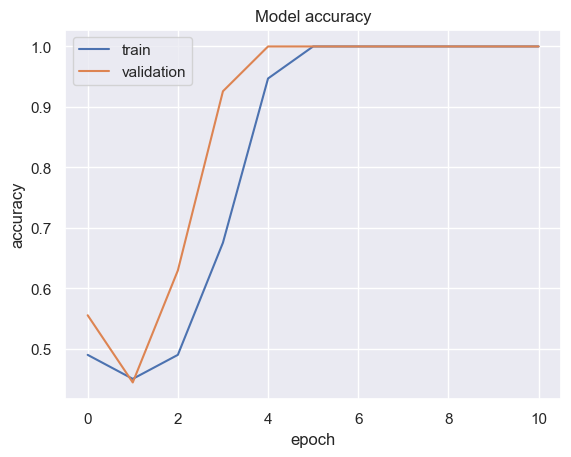

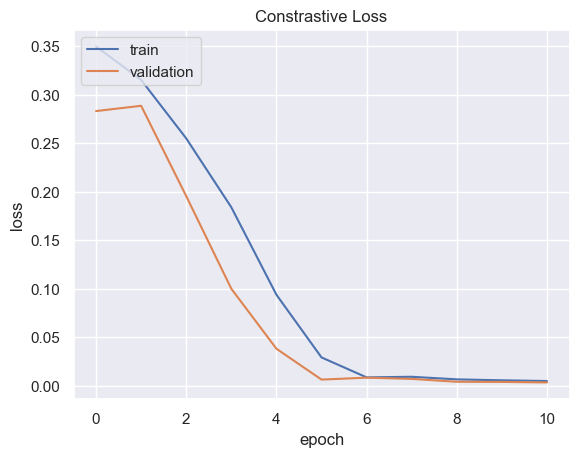

In [230]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

In [231]:
y_pred = siamese_net.predict([x_test_1, x_test_2])

2/2 [==============================] - 0s 2ms/step


In [232]:
results = siamese_net.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

2/2 [==============================] - 0s 4ms/step - loss: 0.0093 - accuracy: 1.0000
test loss, test acc: [0.009330813772976398, 1.0]


In [233]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(10, 3))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.plot(pairs[i][0])
        ax.plot(pairs[i][1])
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

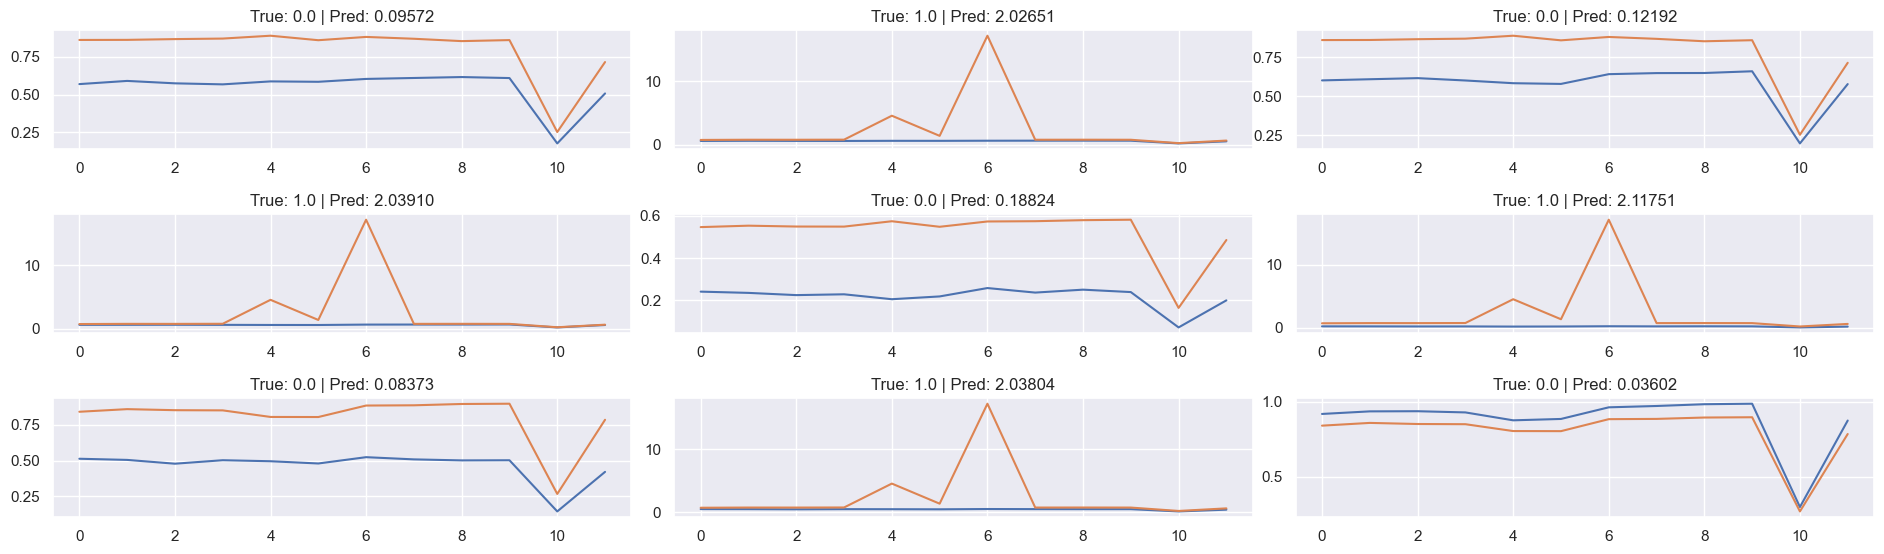

In [234]:
visualize(pairs_test, labels_test, to_show=10, predictions=y_pred, test=True)

In [235]:
real = [1 if label == 1 else 0 for label in labels_test]
pred = [1 if pred > 1 else 0 for pred in y_pred]

<Axes: >

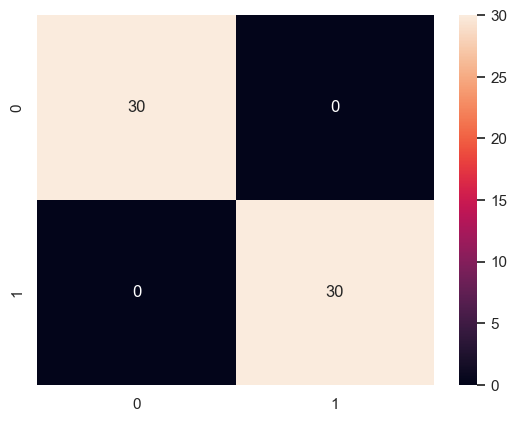

In [236]:
sns.heatmap(confusion_matrix(real, pred), annot=True)